In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", )

date_ran = !date
print("Script run on", date_ran[0])


Script run on Sa 3. Apr 19:45:49 CEST 2021


# 1. Fact
## SWAPI - The Star Wars API
### Height & weight relation of characters

In [2]:
import swapi
swapi.settings.BASE_URL = "https://swapi.dev/api"

people = swapi.get_all(swapi.PEOPLE)

In [3]:
person_list = []

for p in people.items:
    if p.get_species().count() > 0:
        species = p.get_species().items[0].classification
    else:
        species = 'N/A'

    person_list.append([p.name,
                        species,
                        p.birth_year,
                        p.gender,
                        p.height,
                        p.mass,
                        p.hair_color,
                        p.skin_color,
                        p.eye_color,
                        ])

person_df = pd.DataFrame(person_list,
                         columns=['Name', 'Species Class', 'Born', 'Gender', 'Height', 'Mass', 'Hair Color', 'Skin Color', 'Eye Color'])

person_df['Mass'] = pd.to_numeric(person_df['Mass'], errors="coerce")
person_df['Height'] = pd.to_numeric(person_df['Height'], errors="coerce")

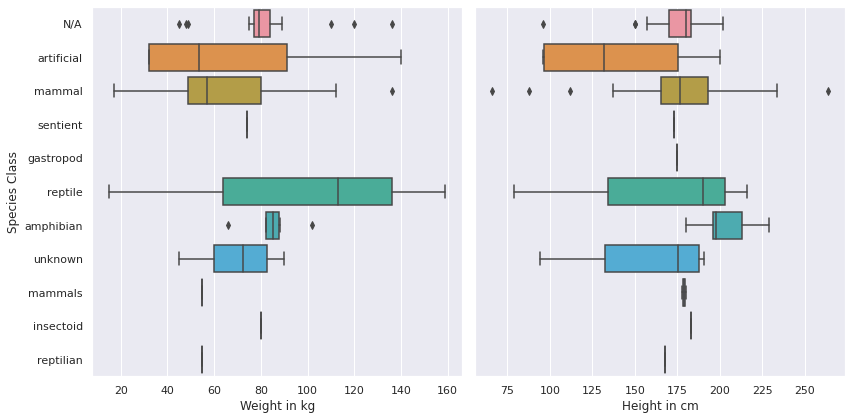

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True)

g1 = sns.boxplot(x="Mass", y="Species Class",
                 data=person_df, ax=ax1)

g2 = sns.boxplot(x="Height", y="Species Class",
                 data=person_df, ax=ax2)

g1.set_xlabel("Weight in kg")
g2.set_xlabel("Height in cm")
g2.set_ylabel("")

fig.tight_layout()
plt.show()

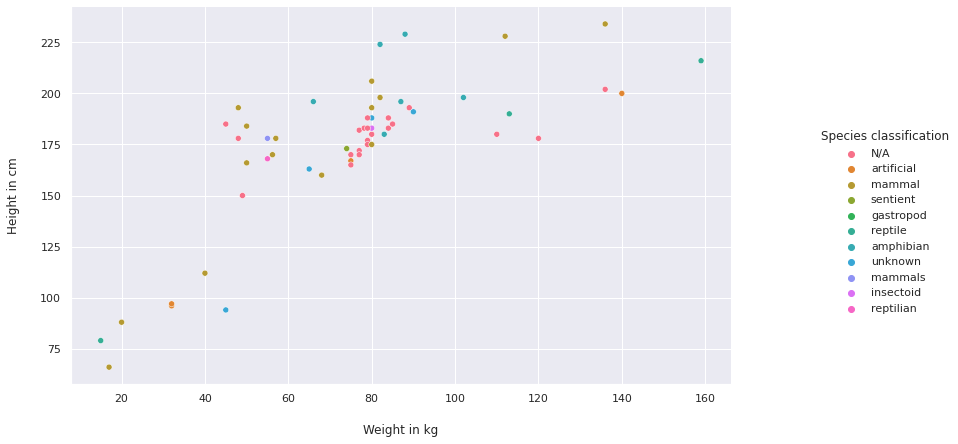

In [5]:
sp = sns.relplot(data=person_df, x='Mass', y='Height', hue="Species Class", legend="full")

sp.set_axis_labels("Weight in kg", "Height in cm", labelpad=20)
sp.legend.set_title("Species classification")

sp.fig.set_size_inches(14, 6)

fig.tight_layout()
plt.show()

# 2. Fact
## The One API - The Lord of the Rings
### Correlations

In [6]:
USE_API = False

if USE_API:
    import requests
    import theoneapi_config

    ENDPOINT = theoneapi_config.endpoint
    HEADERS_WITH_APIKEY = theoneapi_config.headers

    def the_one_api_call(resource):
        if resource.startswith("/"):
            resource = "/" + resource

        response = requests.get(ENDPOINT + resource, headers=HEADERS_WITH_APIKEY)

        if response:
            return response.json()
        else:
            raise requests.HTTPError

    movies = the_one_api_call("/movie")['docs'][2:]
else:
    import pickle

    movies = None

    with open('theoneapi.pickle', 'rb') as f:
        movies = pickle.load(f)

In [7]:
movies_df = pd.DataFrame.from_dict(movies)
movies_df = movies_df.drop(['_id'], axis = 1)

for column in ['runtimeInMinutes', 'budgetInMillions', 'boxOfficeRevenueInMillions',
               'academyAwardNominations', 'academyAwardWins', 'rottenTomatesScore']:
    movies_df[column] = pd.to_numeric(movies_df[column], errors="coerce")

In [8]:
movies_df

,name,runtimeInMinutes,budgetInMillions,boxOfficeRevenueInMillions,academyAwardNominations,academyAwardWins,rottenTomatesScore
0,The Unexpected Journey,169,200,1021.0,3,1,64
1,The Desolation of Smaug,161,217,958.4,3,0,75
2,The Battle of the Five Armies,144,250,956.0,1,0,60
3,The Two Towers,179,94,926.0,6,2,96
4,The Fellowship of the Ring,178,93,871.5,13,4,91
5,The Return of the King,201,94,1120.0,11,11,95


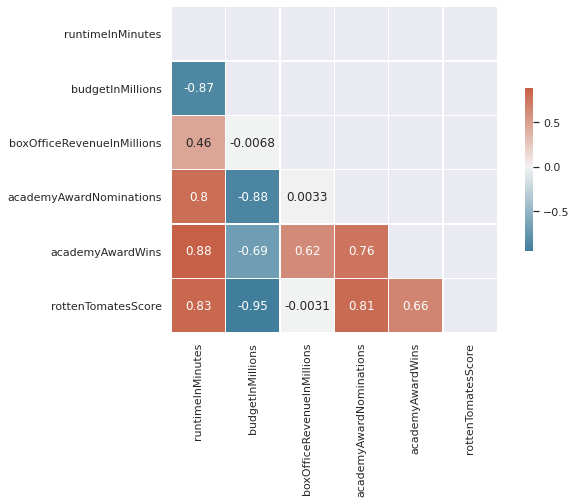

In [9]:
corr = movies_df.corr()

f, ax = plt.subplots(figsize=(10, 6))

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# 3. Fact
## Offene Daten Konstanz - Zu- & Wegzug
### How Corona chase away foreigners from Konstanz

In [10]:
url = "https://offenedaten-konstanz.de/node/41148/download"
wanderung = pd.read_csv(url, sep=';')

wanderung['Zuzugsgebiet_Wegzugsgebiet'] = wanderung['Zuzugsgebiet_Wegzugsgebiet'].str.strip()

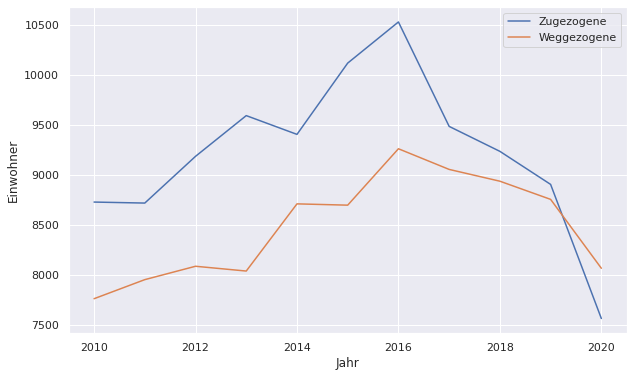

In [11]:
zuzug = [column for column in wanderung.columns if "_ Zuzug" in column]
wegzug = [column for column in wanderung.columns if "_ Wegzug" in column]

years = list(range(2010, 2010+len(zuzug)))

f, ax = plt.subplots(figsize=(10, 6))

g = sns.lineplot(x=years, y=wanderung[zuzug].sum(), label="Zugezogene")
sns.lineplot(x=years, y=wanderung[wegzug].sum(), label="Weggezogene")

g.set_xlabel('Jahr')
g.set_ylabel("Einwohner")

plt.show()

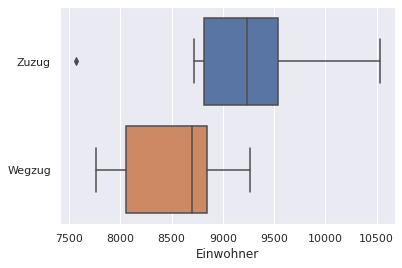

In [12]:
wegzuzug_df = pd.DataFrame({"Zuzug": wanderung[zuzug].sum(), "Wegzug": wanderung[wegzug].sum()}, columns=["Zuzug", "Wegzug"])

g = sns.boxplot(data=wegzuzug_df, orient="h")
g.set_xlabel("Einwohner")

plt.show()

# 4. Fact
## COVID-19 Datenhub - RKI Altersgruppen
### Infected men more likely to die than others

In [13]:
url = "https://opendata.arcgis.com/datasets/23b1ccb051f543a5b526021275c1c6e5_0.csv"
rki_df = pd.read_csv(url, sep=',')

rki_df = rki_df.loc[:, "Altersgruppe":"AnzTodesfallW"]
rki_df = rki_df.groupby(['Altersgruppe'], as_index=False).sum()

In [14]:
rki_gendered_df = pd.DataFrame(columns=["Altersgruppe", "Geschlecht",
                                        "Anzahl der Fälle", "Anzahl der Todesfälle"])

for i, j in rki_df.iterrows():
    rki_gendered_df = rki_gendered_df.append({
        "Altersgruppe": j["Altersgruppe"],
        "Geschlecht": "männlich",
        "Anzahl der Fälle": j["AnzFallM"],
        "Anzahl der Todesfälle": j["AnzTodesfallM"],
    }, ignore_index=True)

    rki_gendered_df = rki_gendered_df.append({
        "Altersgruppe": j["Altersgruppe"],
        "Geschlecht": "weiblich",
        "Anzahl der Fälle": j["AnzFallW"],
        "Anzahl der Todesfälle": j["AnzTodesfallW"],
    }, ignore_index=True)

In [15]:
rki_gendered_df

,Altersgruppe,Geschlecht,Anzahl der Fälle,Anzahl der Todesfälle
0,A00-A04,männlich,96792,6
1,A00-A04,weiblich,89418,15
2,A05-A14,männlich,275868,9
3,A05-A14,weiblich,250965,12
4,A15-A34,männlich,1233564,207
5,A15-A34,weiblich,1242477,120
6,A35-A59,männlich,1561341,5448
7,A35-A59,weiblich,1708140,2367
8,A60-A79,männlich,647949,41391
9,A60-A79,weiblich,655884,21582


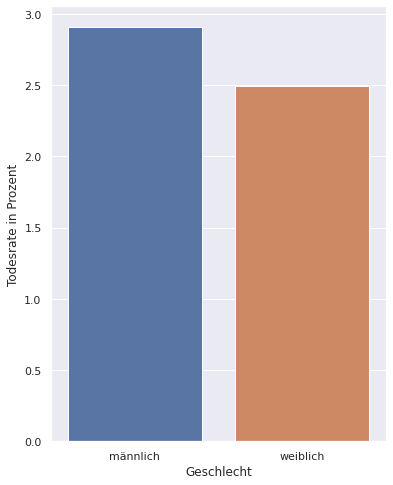

In [16]:
deathrate_df = rki_gendered_df.groupby(['Geschlecht'], as_index=False).sum()

fig, ax = plt.subplots(1, 1, figsize=(6,8))

g = sns.barplot(x=deathrate_df['Geschlecht'],
                y=(deathrate_df['Anzahl der Todesfälle']/deathrate_df['Anzahl der Fälle'])*100)

g.set_ylabel("Todesrate in Prozent")

plt.show()

# 5. Fact
## COVID-19 Datenhub - RKI Altersgruppen
### Deathrate increases with age

In [17]:
rki_agegroups_df = rki_gendered_df.groupby(['Altersgruppe'], as_index=False).sum()
del rki_agegroups_df['Geschlecht']

rki_agegroups_df['Todesrate'] = (rki_agegroups_df['Anzahl der Todesfälle']/rki_agegroups_df['Anzahl der Fälle'])*100

rki_agegroups_df

,Altersgruppe,Anzahl der Fälle,Anzahl der Todesfälle,Todesrate
0,A00-A04,186210,21,0.011278
1,A05-A14,526833,21,0.003986
2,A15-A34,2476041,327,0.013207
3,A35-A59,3269481,7815,0.239029
4,A60-A79,1303833,62973,4.829836
5,A80+,790722,158889,20.094167


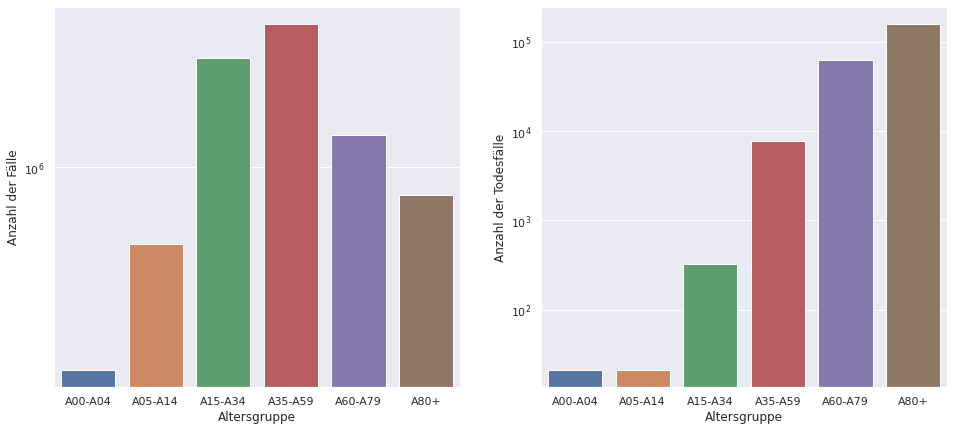

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))

ax1.set(yscale='log')
ax2.set(yscale='log')

sns.barplot(ax=ax1, data=rki_agegroups_df,
            x='Altersgruppe', y="Anzahl der Fälle")

sns.barplot(ax=ax2, data=rki_agegroups_df,
            x='Altersgruppe', y="Anzahl der Todesfälle")

plt.show()

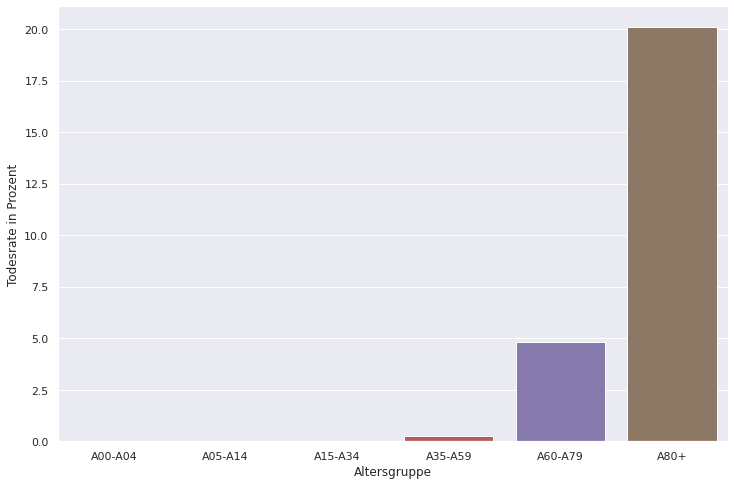

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

g = sns.barplot(data=rki_agegroups_df,
            x='Altersgruppe', y="Todesrate")

g.set_ylabel("Todesrate in Prozent")

plt.show()